# LGBM with pycaret



In [1]:
import numpy as np
import pandas as pd
import os
import random
import pickle
from pycaret.classification import *
from pycaret.utils import check_metric
from datetime import timedelta, timezone, datetime

# 데이터 가져오기

In [2]:
data_dir = '/opt/ml/input/data/train_dataset'
output_dir = '/opt/ml/p4-dkt-feedgate/lgbm_output/서일님'

train_path = os.path.join(data_dir, 'tuning_train_data_bm.csv')
test_path = os.path.join(data_dir, 'tuning_test_data_bm.csv')
# submission_path = os.path.join(output_dir, 'submission.csv')

In [3]:
df_train_ori = pd.read_csv(train_path) 
df_test_ori = pd.read_csv(test_path)

answerCode2bool = {'userID':object,  'answerCode': 'int16', 'KnowledgeTag':object}
df_train_ori = df_train_ori.astype(answerCode2bool)
df_test_ori = df_test_ori.astype(answerCode2bool)
df_train_ori.Timestamp = pd.to_datetime(df_train_ori.Timestamp)
df_test_ori.Timestamp = pd.to_datetime(df_test_ori.Timestamp)

# EDA & Feature Engineering

In [4]:
df_train_ori.head(2)

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,item,item_order,test_size,retest,user_test_ans_cnt,user_test_correct_cnt,user_acc,relElapsedTime,isTest,isPostponed,postpone_mean,postpone_sum,Time,elapsed_time,prob_mean_time,user_time_sum,user_time_mean,user_test_time_sum,moving_average_time,hour,weekday,past_prob_count,past_prob_correct,average_prob_correct,prob_mean,prob_sum,prob_mean_cate,past_test_count,past_test_correct,average_test_correct,test_mean,test_sum,past_tag_count,past_tag_correct,average_tag_correct,tag_mean,tag_sum,cate_mean,cate_sum,past_user_count,past_user_correct,average_user_correct,average_user_correct_cate,moving_average_user_correct_10,moving_average_user_correct_5,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,0,0,6,0,0,0.0,0.0,0.500000,0,0,0.004,1,1585009031,3.0,13.660,0.0,0.0,3.0,0.0,0,1,163,162.0,0.993865,0.984,246,9,978,945.0,0.966258,0.952667,1429,365,356.0,0.975342,0.957333,718,0.712279,211037,0,0.0,0.0,0,0.6,0.8,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1,1,6,0,1,1.0,1.0,0.571429,0,0,0.000,0,1585009034,8.0,26.112,3.0,3.0,11.0,0.0,0,1,163,159.0,0.975460,0.968,242,9,979,946.0,0.966292,0.952667,1429,1743,1587.0,0.910499,0.917067,3439,0.712279,211037,1,1.0,1.0,10,0.6,0.8,0,0.0,0.0,1,1.0,1.0,0,0.0,0.0


In [5]:
# 맞춰야하는 문항 ID 파악
set_assessmentItemID = set(df_test_ori.loc[df_test_ori.answerCode == -1, 'assessmentItemID'].values)

In [6]:
def feature_engineering(df):
    
    # 카테고리형 feature들
    cat_features = ['userID','assessmentItemID','testId','KnowledgeTag','Category','Number','hour','weekday', 
                    'prob_mean_cate','average_user_correct_cate','moving_average_user_correct_10','moving_average_user_correct_5','past_user_prob_count']
    
    for i in enumerate (cat_features) : 
        ca = i[1] 
        df[ca] = df[ca].astype('category') 

    return df

In [7]:
df_test = feature_engineering(df_test_ori)
df = feature_engineering(df_train_ori)
# 피처를 대충만들어서 꽤 오래걸립니다.

In [8]:
df.dtypes

Unnamed: 0                                 int64
userID                                  category
assessmentItemID                        category
testId                                  category
answerCode                                 int16
Timestamp                         datetime64[ns]
KnowledgeTag                            category
Category                                category
Number                                  category
item                                       int64
item_order                                 int64
test_size                                  int64
retest                                     int64
user_test_ans_cnt                          int64
user_test_correct_cnt                    float64
user_acc                                 float64
relElapsedTime                           float64
isTest                                     int64
isPostponed                                int64
postpone_mean                            float64
postpone_sum        

In [9]:
df_test_shift = df_test[df_test['userID'] != df_test['userID'].shift(-1)]

## 엔지니어링 이후의 EDA

In [10]:
for i in range(14):
    order = df.loc[(df.item_order == df.user_test_ans_cnt) & (df.user_test_ans_cnt >= i),'answerCode'].mean()
    deorder = df.loc[(df.item_order != df.user_test_ans_cnt) & (df.user_test_ans_cnt >= i),'answerCode'].mean()
    print(order,deorder)

# 섞어서 풀면 인간의 성능이 항상 떨어진다고 생각했는데, 마지막 2놈은 아니었다.
# 그 와중에 뒤로 갈 수록 정답률 떨어지는건 신기하네

0.6624658036224673 0.5182486920262774
0.6439186285734882 0.5084225999391748
0.6232205172483117 0.4963426269479487
0.5989661078645218 0.48234143387789796
0.5637783249433571 0.4696193708709619
0.5268748949834774 0.4559906770157655
0.494829097283085 0.4438200261548793
0.4619607360452951 0.4351367459108668
0.48256888103462126 0.4208881945994198
0.4796472880139444 0.3949232585596222
0.4258128078817734 0.3718446601941748
0.34984789222077356 0.37168141592920356
0.20306513409961685 0.25
nan nan


In [11]:
# 시험지를 여러번 푼 경우
# 이 친구 보면 알겠지만, 나중에 푼다고 잘 푸는건 아님
# 어짜피 2번째 푸는거면 직전 문제들도 어련히 잘 풀었겠지
df[(df.userID == 1069)  & (df.testId =='A080000127')] 

,Unnamed: 0,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,item,item_order,test_size,retest,user_test_ans_cnt,user_test_correct_cnt,user_acc,relElapsedTime,isTest,isPostponed,postpone_mean,postpone_sum,Time,elapsed_time,prob_mean_time,user_time_sum,user_time_mean,user_test_time_sum,moving_average_time,hour,weekday,past_prob_count,past_prob_correct,average_prob_correct,prob_mean,prob_sum,prob_mean_cate,past_test_count,past_test_correct,average_test_correct,test_mean,test_sum,past_tag_count,past_tag_correct,average_tag_correct,tag_mean,tag_sum,cate_mean,cate_sum,past_user_count,past_user_correct,average_user_correct,average_user_correct_cate,moving_average_user_correct_10,moving_average_user_correct_5,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
740661,740661,1069,A080127001,A080000127,1,2020-12-02 20:40:36,2719,8,A127001,0,0,8,0,0,0.0,0.000000,1.515152,0,0,0.0300,12,1606941636,50.0,64.400000,47218.0,56.889157,50.0,62.666667,20,2,228,142.0,0.622807,0.557500,223,5,1824,949.0,0.520285,0.479987,1535,2188,1178.0,0.538391,0.506929,1646,0.500826,136145,830,430.0,0.518072,5,0.9,0.8,0,0.0,0.0,0,0.0,0.000000,4,1.0,0.250000
740662,740662,1069,A080127002,A080000127,1,2020-12-02 20:41:26,2719,8,A127002,1,1,8,0,1,1.0,1.000000,3.684000,0,0,0.0300,12,1606941686,146.0,63.117500,47268.0,56.880866,196.0,64.000000,20,2,228,115.0,0.504386,0.482500,193,4,1825,950.0,0.520548,0.479987,1535,2189,1179.0,0.538602,0.506929,1646,0.500826,136145,831,431.0,0.518652,5,0.9,0.8,0,0.0,0.0,1,1.0,1.000000,5,2.0,0.400000
740663,740663,1069,A080127003,A080000127,1,2020-12-02 20:43:52,2719,8,A127003,2,2,8,0,2,2.0,1.000000,1.222222,0,0,0.0400,16,1606941832,44.0,40.705000,47414.0,56.987981,240.0,338.333333,20,2,228,134.0,0.587719,0.537500,215,5,1826,951.0,0.520811,0.479987,1535,2190,1180.0,0.538813,0.506929,1646,0.500826,136145,832,432.0,0.519231,5,0.4,0.4,0,0.0,0.0,2,2.0,1.000000,6,3.0,0.500000
740664,740664,1069,A080127004,A080000127,1,2020-12-02 20:44:36,2721,8,A127004,3,3,8,0,3,3.0,1.000000,1.379310,0,0,0.0475,19,1606941876,40.0,41.292500,47458.0,56.972389,280.0,328.000000,20,2,228,100.0,0.438596,0.400000,160,4,1829,954.0,0.521597,0.479987,1535,2124,1022.0,0.481168,0.468594,1686,0.500826,136145,833,433.0,0.519808,5,0.6,0.6,0,0.0,0.0,3,3.0,1.000000,0,0.0,0.000000
740665,740665,1069,A080127005,A080000127,1,2020-12-02 20:45:16,2719,8,A127005,4,4,8,0,4,4.0,1.000000,2.611111,0,0,0.0475,19,1606941916,47.0,24.197500,47498.0,56.952038,327.0,326.333333,20,2,228,122.0,0.535088,0.477500,191,4,1830,955.0,0.521858,0.479987,1535,2193,1183.0,0.539444,0.506929,1646,0.500826,136145,834,434.0,0.520384,5,0.6,0.8,0,0.0,0.0,4,4.0,1.000000,7,4.0,0.571429
740666,740666,1069,A080127006,A080000127,1,2020-12-02 20:46:03,2721,8,A127006,5,5,8,0,5,5.0,1.000000,3.166667,0,0,0.0425,17,1606941963,95.0,58.612500,47545.0,56.940120,422.0,25.333333,20,2,228,132.0,0.578947,0.555000,222,5,1832,957.0,0.522380,0.479987,1535,2125,1023.0,0.481412,0.468594,1686,0.500826,136145,835,435.0,0.520958,5,0.7,1.0,0,0.0,0.0,5,5.0,1.000000,1,1.0,1.000000
740667,740667,1069,A080127007,A080000127,1,2020-12-02 20:47:38,2711,8,A127007,6,6,8,0,6,6.0,1.000000,1.714286,0,0,0.0425,17,1606942058,72.0,39.747500,47640.0,56.985646,494.0,29.333333,20,2,229,115.0,0.502183,0.457500,183,4,1842,961.0,0.521716,0.479987,1535,2700,1205.0,0.446296,0.440656,1344,0.500826,136145,836,436.0,0.521531,5,0.5,0.8,0,0.0,0.0,6,6.0,1.000000,11,2.0,0.181818
740668,740668,1069,A080127008,A080000127,1,2020-12-02 20:48:50,2721,8,A127008,7,7,8,0,7,7.0,1.000000,1.000000,0,0,0.0000,0,1606942130,28.0,106.555276,47712.0,57.003584,522.0,81.666667,20,2,229,89.0,0.388646,0.371859,148,3,1845,964.0,0.522493,0.479987,1535,2131,1027.0,0.481933,0.468594,1686,0.500826,136145,837,437.0,0.522103,5,0.7,0.6,0,0.0,0.0,7,7.0,1.000000,2,2.0,1.000000
740701,740701,1069,A080127001,A

#train/vali 데이터 셋 분리

In [12]:
def my_train_vali_split(df, filter_option = None, train_must_exist_leaderboard = False, ratio=0.5, seed = 23):
    random.seed(seed)
    # 리더보드와 동일 조건의 컬럼 수집
    vali_full = df[(df['userID'] != df['userID'].shift(-1)) & (df.assessmentItemID.isin(set_assessmentItemID))].copy()
    
    # 리더보드와 동일 조건의 컬럼을 나누기
    ratio_r = (1 - ratio)
    vali_1 = vali_full.sample(frac=ratio_r, random_state = seed) # ratio가 1이면, ratio_r이 0이 되어, vali_1에 아무것도 할당되지 않는다.
    vali_2 = vali_full.drop(vali_1.index)

    # vali에 포함된 유저 목록 확인하기
    vali_1_userID = set(vali_1.userID.values)
    vali_2_userID = set(vali_2.userID.values)
    
    # vali에 없는 유저들만 train으로 데려오기
    train_1 = df[ df['userID'].isin(vali_1_userID) == False ].copy()
    train_2 = df[ df['userID'].isin(vali_2_userID) == False ].copy()
    
    # 마지막 응답만 가져올지 여부
    if filter_option == '시험지마지막응답':
        train_1 = train_1[train_1['testId'] != train_1['testId'].shift(-1)].copy()
        train_2 = train_2[train_2['testId'] != train_2['testId'].shift(-1)].copy()
    if filter_option == '사용자마지막응답':
        train_1 = train_1[train_1['userID'] != train_1['userID'].shift(-1)].copy()
        train_2 = train_2[train_2['userID'] != train_2['userID'].shift(-1)].copy()

    # train도 리더보드에서 맞춰야하는 문제(444개 문제)만 볼지 여부
    if train_must_exist_leaderboard:
        train_1 = train_1[train_1.assessmentItemID.isin(set_assessmentItemID)].copy()
        train_2 = train_2[train_2.assessmentItemID.isin(set_assessmentItemID)].copy()
    
    return train_1, vali_1, train_2, vali_2 , vali_full

# LGBM 실험 함수

In [13]:
def exam(datasets ,FEATS, categorical_features=[],numeric_features=[],seed=47):
    train_1, vali_1, train_2, vali_2, vali_full = datasets
    random.seed(seed)
    settings = setup(data=train_1[FEATS], target='answerCode', train_size=0.8, categorical_features=categorical_features, numeric_features=numeric_features, 
                     log_experiment=True, experiment_name='lgbm', log_plots=True, log_profile=True, log_data=True)
    
#     # 15개 모델 중 가장 성능 좋은 3개 저장
#     best_3 = compare_models(sort = 'AUC', n_select = 3)
    
    lgbm = create_model('lightgbm', sort='AUC')
    tuned_lgbm = tune_model(lgbm, optimize = 'AUC', fold = 10)
    final_lgbm = finalize_model(tuned_lgbm)

#     predict_model(lgbm)
#     predict_model(tuned_lgbm)
    predict_model(final_lgbm)

    log = []
    prediction = predict_model(final_lgbm, data=vali_full[FEATS], raw_score = True)
    print(prediction)
    log.append(f"모든 vali 데이터:    {check_metric(prediction['answerCode'], prediction['Label'], metric = 'Accuracy')} ,{check_metric(prediction['answerCode'], prediction['Score_1'], metric = 'AUC')}")
    return final_lgbm, log

# 모델 학습

In [14]:
# filter_option = '시험지마지막응답' # 시험지마지막응답, 사용자마지막응답, None
filter_option = None
# train_must_exist_leaderboard = False # True, False
train_must_exist_leaderboard = True

FEATS = ['average_user_test_correct','prob_mean', 'test_mean', 'answerCode']
FEATS += ['tag_mean', 'user_test_time_sum']

In [15]:
df.columns # FEATS 참고용

Index(['Unnamed: 0', 'userID', 'assessmentItemID', 'testId', 'answerCode',
       'Timestamp', 'KnowledgeTag', 'Category', 'Number', 'item', 'item_order',
       'test_size', 'retest', 'user_test_ans_cnt', 'user_test_correct_cnt',
       'user_acc', 'relElapsedTime', 'isTest', 'isPostponed', 'postpone_mean',
       'postpone_sum', 'Time', 'elapsed_time', 'prob_mean_time',
       'user_time_sum', 'user_time_mean', 'user_test_time_sum',
       'moving_average_time', 'hour', 'weekday', 'past_prob_count',
       'past_prob_correct', 'average_prob_correct', 'prob_mean', 'prob_sum',
       'prob_mean_cate', 'past_test_count', 'past_test_correct',
       'average_test_correct', 'test_mean', 'test_sum', 'past_tag_count',
       'past_tag_correct', 'average_tag_correct', 'tag_mean', 'tag_sum',
       'cate_mean', 'cate_sum', 'past_user_count', 'past_user_correct',
       'average_user_correct', 'average_user_correct_cate',
       'moving_average_user_correct_10', 'moving_average_user_correct_5'

In [16]:
datasets = my_train_vali_split(df, filter_option = filter_option, train_must_exist_leaderboard = train_must_exist_leaderboard, ratio = 1.0) # 어떤 시드를 주던 영향 안받음.

print(len(datasets[0]), len(datasets[4]))
print(datasets[0].answerCode.mean(), datasets[4].answerCode.mean())

107202 4400
0.5593832204623048 0.4827272727272727


In [17]:
train_1, vali_1, train_2, vali_2, vali_full = datasets
random.seed(47)

In [19]:
settings = setup(data=train_1[FEATS], target='answerCode', train_size=0.8, categorical_features=[], numeric_features=[], 
                 log_experiment=True, experiment_name='lgbm', log_plots=True, log_profile=True, log_data=True)

,Description,Value
0,session_id,5914
1,Target,answerCode
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(107202, 6)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [59]:
fold = get_config('fold_generator')
fold

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [57]:
X_train = get_config('X_train')
y_train = get_config('y_train')
y_train

1771680    1
1315712    0
1887566    1
65213      1
296982     0
          ..
355331     1
1305648    0
1043341    1
1998165    1
2049035    1
Name: answerCode, Length: 85761, dtype: int16

In [84]:
for train_idx, test_idx in fold.split(X_train, y_train):
    print(train_idx, test_idx)
    tmp = train_1.reset_index().loc[test_idx]
    print(len(tmp[tmp['answerCode'] == 0]), len(tmp[tmp['answerCode'] == 1]))
    print(len(tmp[tmp['answerCode'] == 0]) / len(tmp))

[ 8557  8558  8559 ... 85758 85759 85760] [   0    1    2 ... 8590 8593 8594]
3611 4966
0.4210096770432552
[    0     1     2 ... 85758 85759 85760] [ 8557  8558  8559 ... 17194 17197 17200]
3719 4857
0.433652052238806
[    0     1     2 ... 85758 85759 85760] [17091 17092 17099 ... 25801 25802 25803]
3669 4907
0.427821828358209
[    0     1     2 ... 85758 85759 85760] [25670 25671 25672 ... 34314 34315 34318]
3588 4988
0.4183768656716418
[    0     1     2 ... 85758 85759 85760] [34281 34283 34284 ... 42878 42880 42881]
3789 4787
0.4418143656716418
[    0     1     2 ... 85758 85759 85760] [42879 42882 42883 ... 51477 51481 51483]
3681 4895
0.42922108208955223
[    0     1     2 ... 85758 85759 85760] [51436 51437 51438 ... 60134 60135 60136]
3768 4808
0.439365671641791
[    0     1     2 ... 85758 85759 85760] [59904 59909 59911 ... 68623 68624 68625]
3716 4860
0.43330223880597013
[    0     1     2 ... 85758 85759 85760] [68585 68590 68592 ... 77183 77192 77194]
3731 4845
0.4350513

In [47]:
lgbm = create_model('lightgbm', sort='AUC')
scores1 = pull()

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7383,0.8121,0.8026,0.7479,0.7743,0.4637,0.4654
1,0.7361,0.8075,0.7999,0.7465,0.7723,0.4595,0.4610
2,0.7477,0.8151,0.8162,0.7534,0.7835,0.4823,0.4845
3,0.7437,0.8118,0.8113,0.7506,0.7798,0.4744,0.4764
4,0.7333,0.8047,0.7955,0.7450,0.7694,0.4540,0.4554
5,0.7399,0.8100,0.8001,0.7511,0.7748,0.4676,0.4689
6,0.7453,0.8160,0.8097,0.7534,0.7805,0.4781,0.4799
7,0.7457,0.8124,0.8095,0.7540,0.7807,0.4789,0.4806
8,0.7530,0.8225,0.8211,0.7576,0.7881,0.4933,0.4956
9,0.7367,0.8094,0.8028,0.7459,0.7733,0.4603,0.4621


In [50]:
scores

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7383,0.8121,0.8026,0.7479,0.7743,0.4637,0.4654
1,0.7361,0.8075,0.7999,0.7465,0.7723,0.4595,0.4610
2,0.7477,0.8151,0.8162,0.7534,0.7835,0.4823,0.4845
3,0.7437,0.8118,0.8113,0.7506,0.7798,0.4744,0.4764
4,0.7333,0.8047,0.7955,0.7450,0.7694,0.4540,0.4554
5,0.7399,0.8100,0.8001,0.7511,0.7748,0.4676,0.4689
6,0.7453,0.8160,0.8097,0.7534,0.7805,0.4781,0.4799
7,0.7457,0.8124,0.8095,0.7540,0.7807,0.4789,0.4806
8,0.7530,0.8225,0.8211,0.7576,0.7881,0.4933,0.4956
9,0.7367,0.8094,0.8028,0.7459,0.7733,0.4603,0.4621


In [51]:
tuned_lgbm = tune_model(lgbm, optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7384,0.8080,0.7982,0.7501,0.7734,0.4646,0.4659
1,0.7374,0.8068,0.7989,0.7486,0.7729,0.4624,0.4638
2,0.7450,0.8134,0.8108,0.7526,0.7806,0.4772,0.4791
3,0.7367,0.8057,0.8049,0.7449,0.7737,0.4600,0.4620
4,0.7337,0.8034,0.7922,0.7470,0.7689,0.4553,0.4564
5,0.7394,0.8091,0.7957,0.7526,0.7735,0.4672,0.4682
6,0.7439,0.8127,0.8065,0.7532,0.7789,0.4755,0.4771
7,0.7415,0.8085,0.8065,0.7501,0.7773,0.4702,0.4720
8,0.7505,0.8195,0.8184,0.7557,0.7858,0.4881,0.4903
9,0.7331,0.8064,0.7961,0.7444,0.7694,0.4534,0.4549


In [22]:
final_lgbm = finalize_model(tuned_lgbm)

Finished loading model, total used 155 iterations
Finished loading model, total used 155 iterations
Finished loading model, total used 155 iterations


In [44]:
# predict_model(lgbm)
# predict_model(tuned_lgbm)
pred_train = predict_model(final_lgbm)
pred_train

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7534,0.8299,0.8146,0.7613,0.7870,0.4950,0.4966


,average_user_test_correct,prob_mean,test_mean,tag_mean,user_test_time_sum,answerCode,Label,Score
0,1.000000,0.207358,0.764299,0.766591,1155.0,0,0,0.6159
1,0.285714,0.265823,0.398284,0.265823,34.5,0,0,0.8561
2,0.666667,0.755853,0.760855,0.791067,143.0,0,1,0.7374
3,0.750000,0.785953,0.665777,0.553657,1019.0,1,1,0.8618
4,1.000000,0.390977,0.591435,0.570052,240.0,0,1,0.6408
...,...,...,...,...,...,...,...,...
21436,0.142857,0.573935,0.590184,0.585746,64.0,0,0,0.7645
21437,0.000000,0.767068,0.755511,0.738046,134.0,1,1,0.6100
21438,0.833333,0.349398,0.634077,0.726337,1163.0,0,0,0.6505
21439,0.800000,0.771044,0.792432,0.791067,307.0,1,1,0.8190


In [46]:
pred_train['Score']

0        0.6159
1        0.8561
2        0.7374
3        0.8618
4        0.6408
          ...  
21436    0.7645
21437    0.6100
21438    0.6505
21439    0.8190
21440    0.6339
Name: Score, Length: 21441, dtype: float64

In [43]:
m = get_metrics()
m

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7f2d64817b90>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<function roc_auc_score at 0x7f2d64807b90>,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, average=macro)",pred,{'average': 'macro'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x7f2d6481c0e0>,make_scorer(cohen_kappa_score),pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x7f2d6481c440>,make_scorer(matthews_corrcoef),pred,{},True,True,False


In [86]:
prediction = predict_model(final_lgbm, data=vali_full[FEATS], raw_score = True)
print(prediction)

         average_user_test_correct  prob_mean  test_mean  answerCode  \
744                       0.600000   0.150376   0.358514           0   
1677                      0.800000   0.478261   0.439189           1   
2786                      0.428571   0.301255   0.494461           0   
6292                      0.750000   0.508361   0.537025           1   
6897                      0.500000   0.496644   0.782377           0   
...                            ...        ...        ...         ...   
2266499                   0.250000   0.682274   0.590394           1   
2266514                   0.500000   0.787149   0.690953           1   
2266561                   0.750000   0.558528   0.774516           1   
2266576                   0.250000   0.575758   0.731463           0   
2266585                   1.000000   0.545151   0.653878           1   

         tag_mean  user_test_time_sum  Label  Score_0  Score_1  
744      0.299311               292.5      0   0.8613   0.1387  
1677 

In [25]:
log = []
log.append(f"모든 vali 데이터:    {check_metric(prediction['answerCode'], prediction['Label'], metric = 'Accuracy')} ,{check_metric(prediction['answerCode'], prediction['Score_1'], metric = 'AUC')}")
print('\n'.join(log))

모든 vali 데이터:    0.7434 ,0.8279


In [26]:
model = final_lgbm
print('\n', model)


 LGBMClassifier(bagging_fraction=0.9, bagging_freq=2, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.9,
               importance_type='split', learning_rate=0.3, max_depth=-1,
               min_child_samples=46, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=190, n_jobs=-1, num_leaves=20, objective=None,
               random_state=5914, reg_alpha=3, reg_lambda=0.0005, silent=True,
               sort='AUC', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


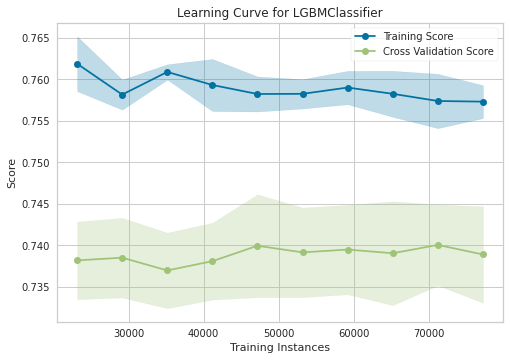

In [32]:
plot_model(estimator = model, plot = 'learning')

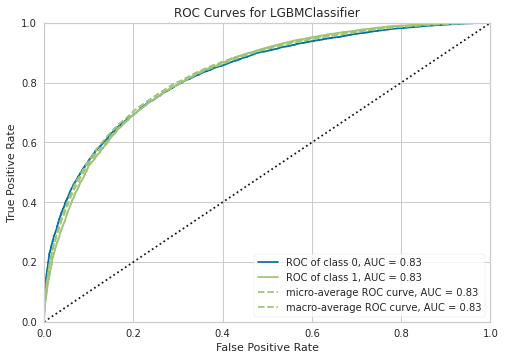

In [33]:
plot_model(estimator = model, plot = 'auc')

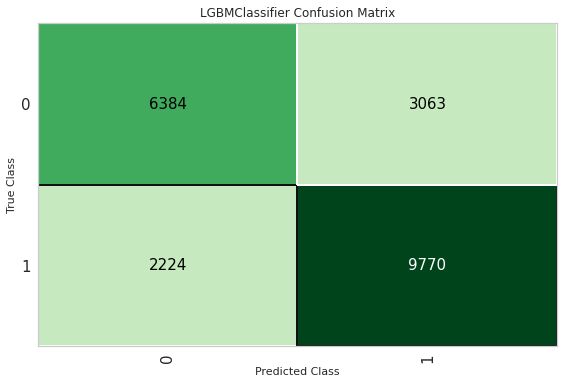

In [34]:
plot_model(estimator = model, plot = 'confusion_matrix')

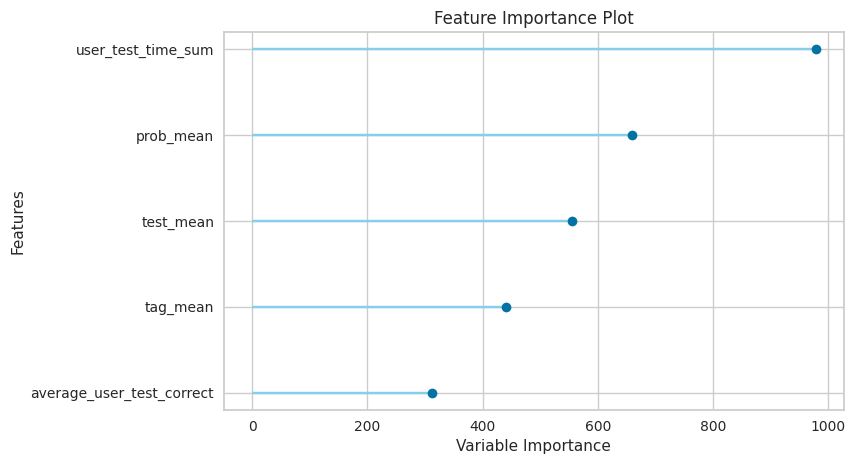

In [30]:
plot_model(estimator = model, plot = 'feature')



# Inference

In [31]:
# # MAKE PREDICTION
# # SAVE OUTPUT

# prediction = predict_model(model, data=df_test_shift[FEATS], raw_score=True)
# total_preds = prediction.Score_1.values

# prediction_name = datetime.now(timezone(timedelta(hours=9))).strftime('%m%d_%H%M')

# write_path = os.path.join(output_dir, f"{prediction_name}.csv")
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)    
# with open(write_path, 'w', encoding='utf8') as w:
#     print("writing prediction : {}".format(write_path))
#     w.write("id,prediction\n")
#     for id, p in enumerate(total_preds):
#         w.write('{},{}\n'.format(id,p))

# name = ('filter_option', 'train_must_exist_leaderboard', 'FEATS', 'log')
# logs = (filter_option, train_must_exist_leaderboard, FEATS,log)
# write_path = os.path.join(output_dir, f"{prediction_name}_log.txt")
# with open(write_path, 'w', encoding='utf8') as w:
#     print("writing prediction : {}".format(write_path))
#     for n, l in zip(name, logs):
#         w.write(f'{n}: {l}\n')

writing prediction : /opt/ml/p4-dkt-feedgate/lgbm_output/서일님/0614_1819.csv
writing prediction : /opt/ml/p4-dkt-feedgate/lgbm_output/서일님/0614_1819_log.txt
